## Heart Disease - Exploratory Data Analysis

### Goal
Our goal in this notebook is to understand which features are associated with heart disease and prepare the ground for a model that predicts whether a patient has heart disease.
### Data overview
The data we use is the [Heart disease data from Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data).
The data has the following variables, taken verbatim from the page:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

### The Notebook plan.

- Dataset overview & data quality (types, missingness, duplicates, class balance).
- Univariate distributions 
- Feature–target relationships
- Correlation/association scan and quick interactions.
- Key findings & modeling implications 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ast
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr, mannwhitneyu
from itertools import combinations

sys.path.append(os.path.abspath(".."))
#few helper functions for summaries, statistics etc
from utils.data_utils import (
    missing_value_summary,
    barplots_cat_univariate,
    cramers_v_table_scipy,
    barplots_by_category_labeled,
    plot_histograms,
    plot_density_by_category,
    outlier_summary,
    numeric_effect_sizes,
    plot_boxplots_by_category,
    barplots_by_category,
    loess_diagnostic_grid
)


In [2]:
data =  pd.read_csv("../data/heart.csv")

### Variables

The dataset contains **918 samples** and 11 features plus the target.  
Feature types are as follows:

- **Numeric features (5):** `Age`, `RestingBP`, `Cholesterol`, `Oldpeak`, `MaxHR`.  
- **Categorical features (6):**  
  - Binary: `Sex`, `FastingBS`, `ExerciseAngina`  
  - Multiclass: `ChestPainType`, `RestingECG`, `ST_Slope`

The target variable is **`HeartDisease`** (`1` = has heart disease, `0` = no heart disease).

Although Python identifies `FastingBS` as numeric (`int64`), it is in fact a **binary categorical** feature based on medical thresholds.


In [3]:
print(data.info())
dict_df = pd.DataFrame({
    "column": data.columns,
    "dtype": data.dtypes.astype(str),
    "n_unique": data.nunique()
}).sort_values("dtype").reset_index(drop=True)
display(dict_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


,column,dtype,n_unique
0,Oldpeak,float64,53
1,Age,int64,50
2,RestingBP,int64,67
3,Cholesterol,int64,222
4,FastingBS,int64,2
5,MaxHR,int64,119
6,HeartDisease,int64,2
7,Sex,object,2
8,ChestPainType,object,4
9,RestingECG,object,3


### Distribution of the Target Variable

The target variable `HeartDisease` is nearly balanced:

- **55%** of patients are positive (`1`: has heart disease).  
- **45%** are negative (`0`: no heart disease).  

This balanced distribution means we do not need to apply strong class rebalancing techniques (e.g., oversampling) before modeling.


Counts:
 HeartDisease
0    410
1    508
Name: count, dtype: int64

Percentages:
 HeartDisease
1    55.0
0    45.0
Name: proportion, dtype: float64


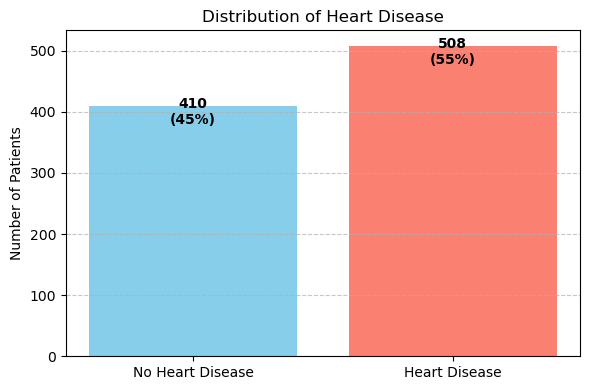

In [4]:
target = data["HeartDisease"]
counts = target.value_counts().sort_index()
percentages = target.value_counts(normalize=True).round(2) * 100

print("Counts:\n", counts)
print("\nPercentages:\n", percentages)


plt.figure(figsize=(6, 4))
bars = plt.bar(
    ["No Heart Disease", "Heart Disease"],
    counts.values,
    color=["skyblue", "salmon"]
)


for bar, pct in zip(bars, percentages.sort_index()):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 35,
        f"{height}\n({pct:.0f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.ylabel("Number of Patients")
plt.title("Distribution of Heart Disease")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Missing Values and Duplicates

A quick data-quality scan shows that the dataset is already clean:

- **Missing values:** None across all columns.  
- **Duplicate rows:** 0 detected.  

This means we do not need imputation or deduplication before proceeding with the exploratory analysis.


In [5]:
missing_values_summary = missing_value_summary(data)
print(missing_values_summary)
dup_rows = data.duplicated().sum()
print("---------------------------------------------------------------")
print(f"\nDuplicate rows: {dup_rows}")

                Number of Missing Values  Percent of Total Values
Age                                    0                      0.0
Sex                                    0                      0.0
ChestPainType                          0                      0.0
RestingBP                              0                      0.0
Cholesterol                            0                      0.0
FastingBS                              0                      0.0
RestingECG                             0                      0.0
MaxHR                                  0                      0.0
ExerciseAngina                         0                      0.0
Oldpeak                                0                      0.0
ST_Slope                               0                      0.0
HeartDisease                           0                      0.0
---------------------------------------------------------------

Duplicate rows: 0


### Train–Test Split
We split 80/20 with stratification on `HeartDisease` to preserve class balance.  
All subsequent data-driven steps (imputation, scaling, encoding) will be **fit on `X_train` only** and applied to `X_test`.


In [6]:
all_vars = list(data.columns)
feature_names = [var for var in all_vars if var != 'HeartDisease']
features = data[feature_names]
target = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=1996,stratify=target)
X_train.to_csv('../data/training_features.csv', index = False)
X_test.to_csv('../data/testing_features.csv', index = False)
y_train.to_csv('../data/training_labels.csv', index = False)
y_test.to_csv('../data/testing_labels.csv', index = False)

#Quick check that indeed the stratification was properly done:
print("\nDistribution of target variable in the test set\n")
print(y_test.value_counts())
print("Percentage:\n")
print(y_test.value_counts(normalize=True).round(2) * 100)

print("\nDistribution of target variable in the training set\n")
print(y_train.value_counts())
print("Percentage:\n")
print(y_train.value_counts(normalize=True).round(2) * 100)


Distribution of target variable in the test set

HeartDisease
1    102
0     82
Name: count, dtype: int64
Percentage:

HeartDisease
1    55.0
0    45.0
Name: proportion, dtype: float64

Distribution of target variable in the training set

HeartDisease
1    406
0    328
Name: count, dtype: int64
Percentage:

HeartDisease
1    55.0
0    45.0
Name: proportion, dtype: float64


In [7]:
num_vars = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
cat_vars = [var for var in list(X_train.columns) if var not in num_vars]
full_train = pd.concat([X_train, y_train], axis=1)

print(num_vars)
print(cat_vars)

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


## Univariate Analysis

### Descriptive statistics - Numerical variables
We summarise the 5 numeric features on the training set to avoid peeking at the test data. In addition to the usual summary stats, we check for potential data-quality issues (zeros/negatives and extreme values) and compute robust percentiles.

- `Age`: has a broad range, with the minimum of 28, median of 54 and maximum of 77, suggesting a wide enough coverage which could potentially help in determining if there is a relationship between `Age` and `HeartDisease.`
- `RestingBP`: nothing major stands out for this variable - the values seem reasonable.
- `Cholesterol`: has a questionable minimum value of 0. This could potentially be some mis-input or erroneous data which we will explore later on. The maximum value of 603 suggests this must be an outlier, especially since the 75th percentile is 265.
- `MaxHR`: range appears plausible for exercise tests.
- `Oldpeak`: further analysis will be done on this variable

In [8]:
X_train[num_vars].describe().round(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,734.00,734.00,734.00,734.00,734.00
mean,53.34,132.65,195.84,136.64,0.87
std,9.37,18.42,110.59,25.66,1.04
min,28.00,80.00,0.00,60.00,-2.00
25%,47.00,120.00,170.00,120.00,0.00
50%,54.00,130.00,222.00,137.00,0.50
75%,60.00,140.00,265.00,156.00,1.50
max,77.00,200.00,603.00,195.00,5.60


### Outlier Analysis

We perform outlier analysis using two common approaches:

- **IQR method**: values outside the range  
  $
  (Q_1 - 1.5 \times IQR,\; Q_3 + 1.5 \times IQR)
 $
- **Z-score method**: values with standardized score outside $(-3, 3)$.

**Observations:**

- **Age**: no outliers under either method, so minimal preprocessing needed.  
- **RestingBP**: flagged **23 high outliers (IQR)** vs **5 (Z-score)**.  
- **Cholesterol**: 145 low outliers (IQR), likely corresponding to the suspicious “0 cholesterol” entries.  
- **MaxHR**: 2 IQR outliers, none by Z-score.  
- **Oldpeak**: 8 outliers under both methods — a modest concern.

**Summary.**  
`Age` and `MaxHR` appear well-behaved.  
`RestingBP`, `Cholesterol`, and `Oldpeak` will need preprocessing, such as:  

- Treating implausible values (e.g. `Cholesterol = 0`) as missing, which will require some form of imputation.  
- Considering power transformations 


In [8]:
outlier_summary(X_train, num_vars, k=1.5, z_thresh=3.0)

,iqr_lower,iqr_upper,iqr_low_n,iqr_high_n,z_lower,z_upper,z_low_n,z_high_n
feature,,,,,,,,
Age,27.50,79.50,0,0,25.26,81.42,0,0
RestingBP,90.00,170.00,1,23,77.42,187.87,0,6
Cholesterol,27.50,407.50,145,8,-135.71,527.38,0,2
MaxHR,66.00,210.00,2,0,59.70,213.58,0,0
Oldpeak,-2.25,3.75,0,8,-2.25,3.99,0,7


### Univariate Distributions: Histograms

We plot histograms of the five numeric features in the training set:

- **Age**: approximately bell-shaped, consistent with prior summaries; no major concerns.  
- **RestingBP**: multimodal with several peaks, but values lie within reasonable clinical ranges.  
- **Cholesterol**: the spike at 0 stands out — likely erroneous entries that could bias models if left untreated.  
- **MaxHR**: appears bimodal with peaks around 120 and 150; this may partly reflect bin choice, but is worth noting.  
- **Oldpeak**: heavily right-skewed with a mode at 0 (299/734 cases, ≈41%). The second most frequent value is 1 (66 cases). Only 49 unique values exist, suggesting a large proportion of ties.

**Summary.**  
Most numeric variables are reasonably distributed, with the exception of `Cholesterol` (implausible zeros) and `Oldpeak` (heavily skewed with mass at 0). These may require special handling before modeling.  


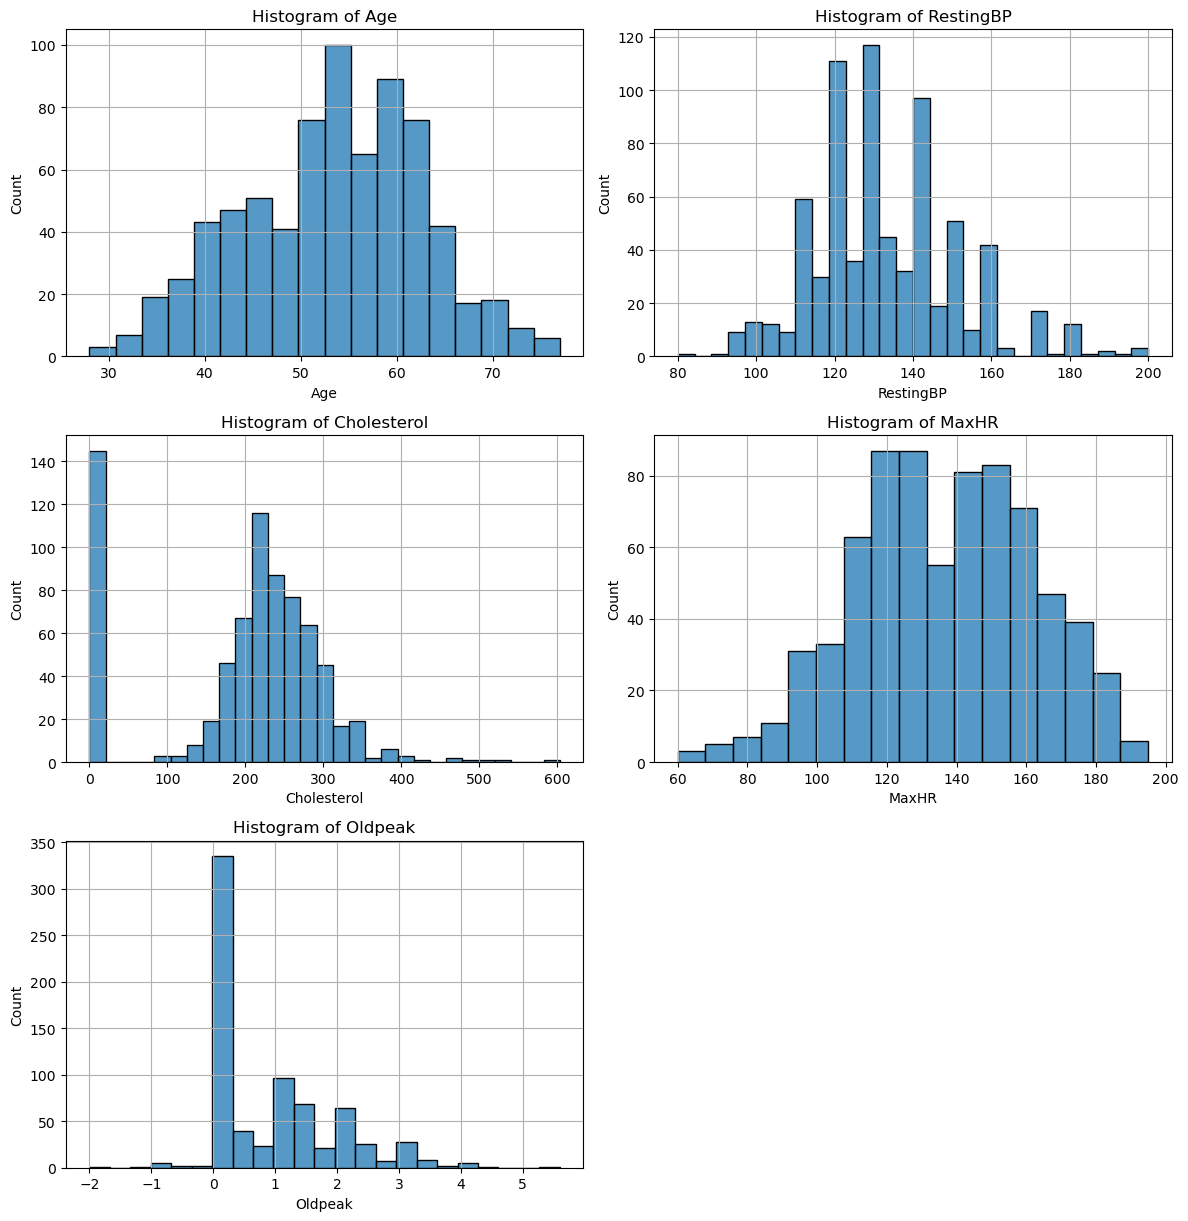

In [9]:
plot_histograms(X_train,num_vars) #custom function found in data_utils.

In [11]:
print("Number of unique values in Oldpeak: ",len(X_train['Oldpeak'].unique()))
print("\nMost frequently occuring values in Oldpeak: ")
print(X_train['Oldpeak'].value_counts().head())

Number of unique values in Oldpeak:  49

Most frequently occuring values in Oldpeak: 
Oldpeak
0.0    299
1.0     66
2.0     59
1.5     41
3.0     25
Name: count, dtype: int64


## Bivariate Analysis and Relation to Target

### Correlations among numeric features

We compute **Spearman rank correlations** between the numeric variables in the training set.  

**Observations:**
- The highest (in absolute value) correlation is between **Age and MaxHR** (-0.34).  
- **Age and RestingBP** (0.28) and **Age and Oldpeak** (0.27) are next.  
- Most other correlations are weak (<0.20 in absolute value).  
- The weakest associations are **Cholesterol–RestingBP** (0.10) and **Cholesterol–Oldpeak** (0.03).  

In summary,  none of the numeric features are highly correlated. This suggests **low risk of multicollinearity**, so all features can be retained for modeling without immediate concern.


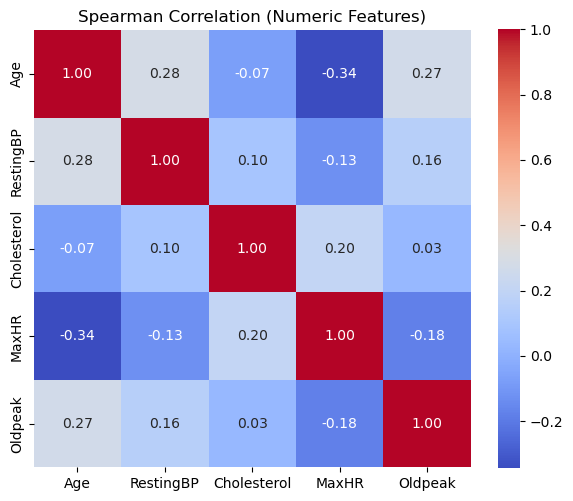

In [10]:
corr_spearman = X_train[num_vars].corr(method="spearman")
plt.figure(figsize=(6,5))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation (Numeric Features)")
plt.tight_layout(); plt.show()

In [11]:
corr_matrix = corr_spearman.round(2)
np.fill_diagonal(corr_matrix.values, np.nan)
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_long = corr_long[corr_long['Variable 1'] < corr_long['Variable 2']]
corr_long = corr_long.reindex(corr_long['Correlation'].abs().sort_values(ascending=False).index)
print("\nCorrelations between numeric variables sorted by descending strength in (absolute) correlation:\n")
corr_long


Correlations between numeric variables sorted by descending strength in (absolute) correlation:



,Variable 1,Variable 2,Correlation
3,Age,MaxHR,-0.34
1,Age,RestingBP,0.28
4,Age,Oldpeak,0.27
13,Cholesterol,MaxHR,0.20
19,MaxHR,Oldpeak,-0.18
21,Oldpeak,RestingBP,0.16
16,MaxHR,RestingBP,-0.13
11,Cholesterol,RestingBP,0.10
2,Age,Cholesterol,-0.07
14,Cholesterol,Oldpeak,0.03


### Correlations between Numeric Features and Target

We summarise numeric to target association with two effect sizes:
- **Point–biserial** $(r_{pb}$): linear association (Pearson with binary target).
- **Rank–biserial** $(r_{rb}$): distribution-free effect from Mann–Whitney; $P(X_1>X_0)=(r_{rb}+1)/2$.

**Largest observed associations (by |r|):**
- **Oldpeak**: $r_{pb}=+0.41$ - higher ST-depression may imply higher prevalence.
- **MaxHR**: $r_{pb}=-0.38$ - higher max HR may imply lower prevalence.
- **Age**: $r_{pb}=+0.28$ - older patients may imply higher prevalence.
- **Cholesterol**: $r_{pb}=-0.23$ as-is, but **excluding 145 zeros** flips to $r_{pb}=+0.13$ (direction changes; magnitude weak) so the zeros are likely non-physiologic placeholders.
- **RestingBP**: $r_{pb}=+0.14$ - weak positive association.

Note that with $n\approx734$, p-values will be tiny even for weak effects; effect sizes and per-class medians are the informative pieces here.

In [12]:
full_effects, important_effects = numeric_effect_sizes(X_train, y_train, num_vars,
                                                       thr_pb=0.20, thr_rb=0.20)
print("Important numeric features (by |r| thresholds):")
display(important_effects)

Important numeric features (by |r| thresholds):


,feature,r_pointbiserial,rank_biserial,P(X1>X0),median_0,median_1
0,Oldpeak,0.409,0.463,0.731,0.0,1.2
1,MaxHR,-0.380,-0.446,0.277,150.0,126.0
2,Age,0.280,0.341,0.670,51.0,57.0
3,Cholesterol,-0.227,-0.155,0.423,225.0,217.0


In [25]:
mask = X_train["Cholesterol"] != 0
pb_no_zero = {c: pointbiserialr(X_train.loc[mask, c], y_train.loc[mask])[0]
              for c in ["Cholesterol"]}
print(pb_no_zero)

{'Cholesterol': np.float64(0.13162572731704247)}


#### KDE plots of numerical variables by target

We compare per-class densities for each numeric feature.

- **Age**: the `HeartDisease=1` density peaks at a higher age than `=0`, indicating clear univariate separation.
- **RestingBP**: little separation between classes; weak univariate signal.
- **MaxHR**: `HeartDisease=1` concentrates at lower values than `=0`, showing clear separation.
- **Cholesterol**: the mass at **0** creates a spike that KDEs smooth imperfectly; naïvely it looks higher for `HeartDisease=1`, but this is driven by implausible zeros.
- **Oldpeak** (many zeros): heavy mass at 0 and right-skew can distort KDE.

We do KDEs are bandwidth-sensitive and can be biased at boundaries. So we treat spikes at special values (e.g., 0) with care. The visuals below reflect **univariate** separation only; multivariate models may differ.


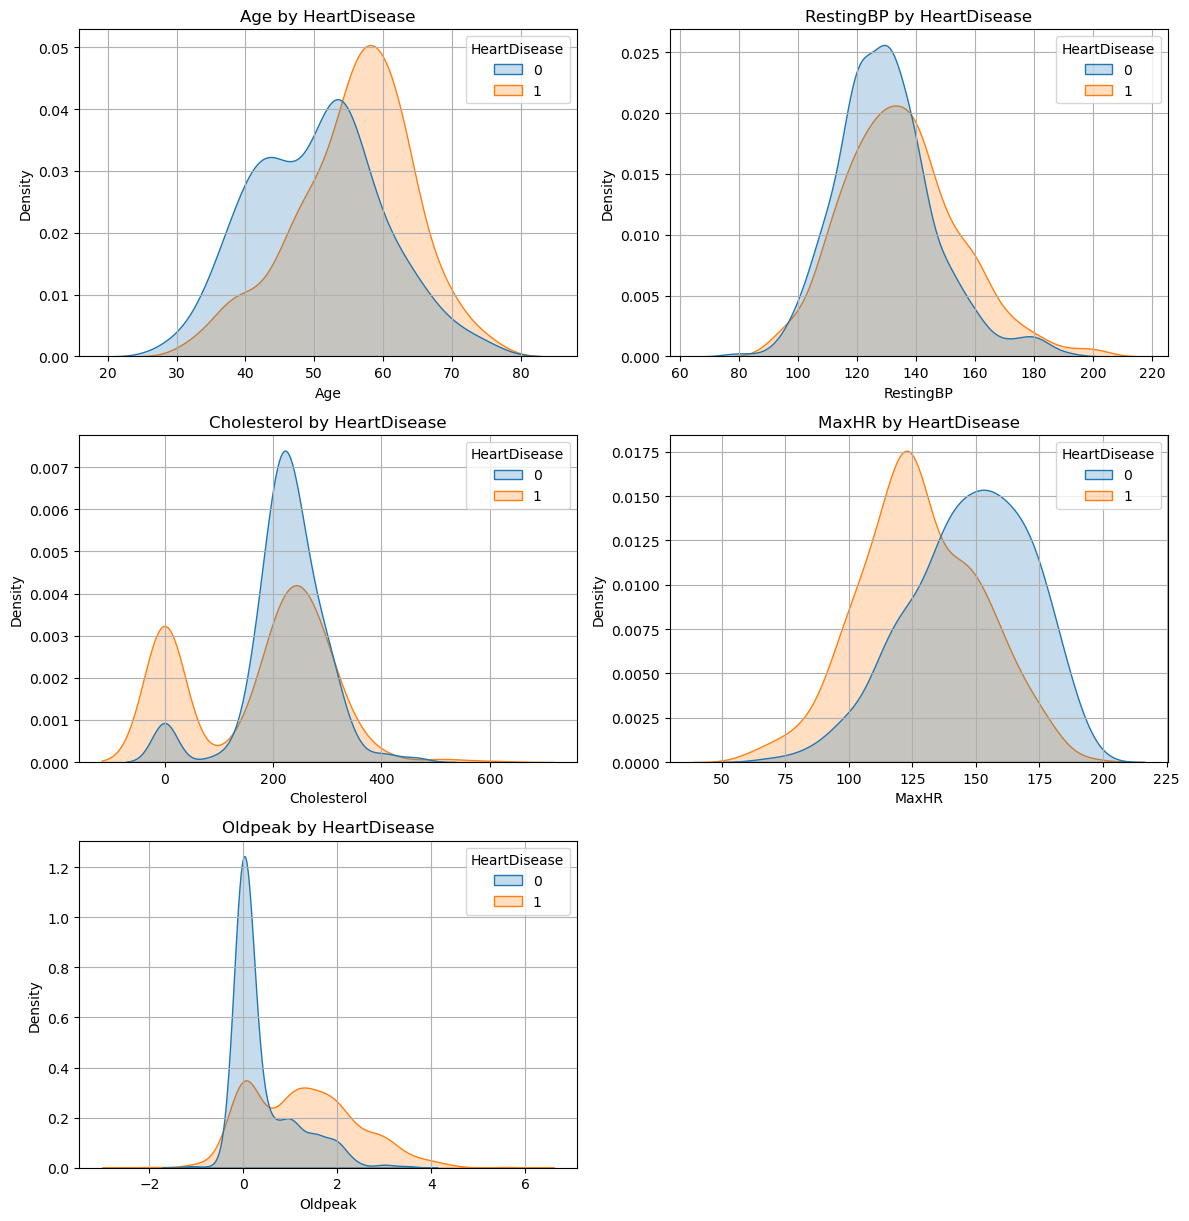

In [13]:
numerical_and_target =  pd.concat([X_train[num_vars], y_train], axis=1)
plot_density_by_category(numerical_and_target, num_vars, 'HeartDisease', n_cols=2) #utility function in data utils

#### Box plots of numerical variables by target

Boxplots provide a compact summary of distribution shifts and outliers.  
The patterns are consistent with the KDE plots:

- Patients with heart disease are, on average, older.  
- Lower `MaxHR` is associated with heart disease.  
- Boxplots also highlight extreme values (e.g. `Cholesterol` outliers, `Oldpeak` skew) more explicitly than KDEs.


In [14]:
g = X_train.join(y_train.rename("HeartDisease")).groupby("HeartDisease")[num_vars]

means   = g.mean()
medians = g.median()

tbl = pd.DataFrame({
    "mean_no":     means.loc[0],
    "mean_yes":    means.loc[1],
    "delta_mean":  means.loc[1] - means.loc[0],
    "median_no":   medians.loc[0],
    "median_yes":  medians.loc[1],
    "delta_median":medians.loc[1] - medians.loc[0],
}).loc[num_vars].round(2)


tbl = tbl.reindex(tbl["delta_mean"].abs().sort_values(ascending=False).index)

tbl

,mean_no,mean_yes,delta_mean,median_no,median_yes,delta_median
Cholesterol,223.72,173.31,-50.41,225.0,217.0,-8.0
MaxHR,147.47,127.89,-19.58,150.0,126.0,-24.0
RestingBP,129.71,135.02,5.31,130.0,133.5,3.5
Age,50.42,55.70,5.27,51.0,57.0,6.0
Oldpeak,0.40,1.25,0.86,0.0,1.2,1.2


## Loess Diagnostic
The LOESS diagnostics show clear non-linear patterns for several predictors (notably those with higher rmse_lowess_vs_logit). The AUC gain appears minimal but we will nonetheless include polynomial/spline features for these variables in the modeling notebook and reassess via cross-validated performance and calibration.

,variable,rmse_lowess_vs_logit,auc_deg1,auc_deg2,auc_gain,flagged_nonlinear,n_eff
0,Age,0.051423,0.668516,0.668516,0.00000,True,918
1,RestingBP,0.069075,0.565257,0.567237,0.00198,True,918
2,Cholesterol,0.053437,0.566092,0.566092,0.00000,True,746
3,MaxHR,0.056994,0.734236,0.734236,0.00000,True,918
4,Oldpeak,0.231052,0.735324,0.735324,0.00000,True,918


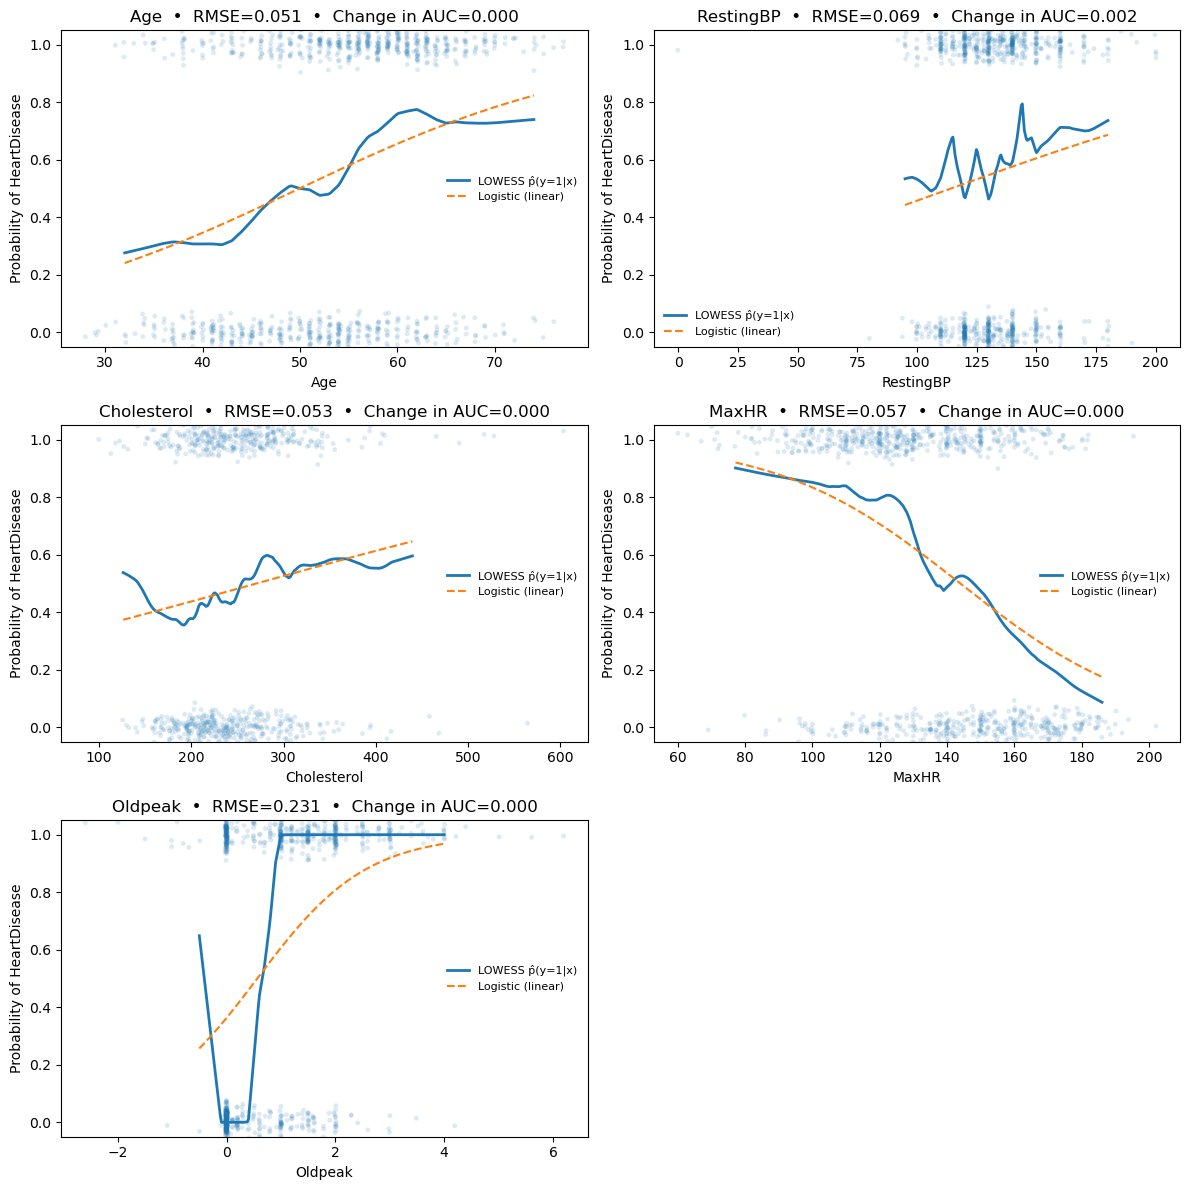

In [9]:
summary_loess = loess_diagnostic_grid(
    data,
    numeric_vars=num_vars,
    target="HeartDisease",
    frac=0.25,
    logistic_C=1.0,
    n_cols=2,
    handle_zeros_for=("Cholesterol",)  # ignore 0s in Cholesterol for smoothing
)
summary_loess

## Summary of Findings: Continuous Variables 

### Data quality & distributions
- `Cholesterol` contains many zeros, which distort distributional summaries and correlations.  
  *Action*: handle explicitly in preprocessing (e.g., treat as missing + indicator).
- Other numerics (`Age`, `RestingBP`, `MaxHR`, `Oldpeak`) show reasonable ranges with some skew.

### Association with the target
- **Strongest signals**  
  - `Oldpeak`: positive association with HeartDisease (strongest).  
  - `MaxHR`: negative association (second strongest).  
  - `Age`: positive association (moderate).  
- **Weaker signals**  
  - `RestingBP`: small positive effect.  
  - `Cholesterol`: negative correlation, but unreliable due to zeros.

### Statistical checks
- Mann–Whitney U tests support the differences observed in plots.  
- Per-class summaries: HeartDisease cases tend to have **higher `Oldpeak` and `Age`**, and **lower `MaxHR`**.

### Nonlinearity (LOESS)
- LOESS vs. linear-logit fits show **clear curvature** for several predictors (especially `Oldpeak`, moderate for `Age`/`MaxHR`).  
- Suggests trying **polynomial/spline features** in the modeling stage.

---

### Implications for Modeling
- **Feature engineering**  
  - Add polynomial/spline terms for `Oldpeak`, possibly `Age` and `MaxHR`.  
  - Consider simple interactions.
- **Data handling**  
  - Special treatment for `Cholesterol` zeros (indicator + imputation strategy).  
  - Standardize numeric features for logistic/regularized models.
- **Baseline vs. curved models**  
  - Start with logistic (degree-1).  
  - Compare against logistic with polynomial features.  
  - Benchmark with tree-based models for nonparametric perspective.


### Continuous Variables: Quick Reference Table

| Variable     | Correlation with Target | Median (No HD) | Median (HD) | Direction (HD vs No) | LOESS Nonlinearity |
|--------------|-------------------------|----------------|-------------|-----------------------|---------------------|
| **Oldpeak**  | +0.41 (strong)          | 0.0            | 1.6         | Higher in HD          | **Yes** (curved)    |
| **MaxHR**    | –0.38 (strong)          | 156            | 129         | Lower in HD           | **Yes** (curved)    |
| **Age**      | +0.28 (moderate)        | 52             | 56          | Higher in HD          | Mild                |
| RestingBP    | +0.14 (weak)            | 130            | 134         | Slightly higher in HD | Yes                |
| Cholesterol* | –0.23 (weak, caveat)    | 244            | 223         | Lower in HD           | Unclear (zeros)     |

\* `Cholesterol` values include many zeros; interpret with caution.


## Categorical Variables

We have six categorical predictors:

- **Sex**  
  - Highly imbalanced: ~80% male, ~20% female.  
- **ChestPainType**  
  - Four categories: ASY (Asymptomatic) dominates (~53%), NAP (Non-anginal Pain) and ATA (Atypical Angina) moderate shares, TA (Typical Angina) rare (~5%).  
- **FastingBS**  
  - Binary: 0 (<120 mg/dl) makes up ~77%, 1 (≥120 mg/dl) ~23%.  
- **RestingECG**  
  - Three categories: Normal (~61%) vs. LVH/ST (roughly split the remainder).  
- **ExerciseAngina**  
  - Mostly “No” (~60%), “Yes” ~40%.  
- **ST_Slope**  
  - Split between Flat (~51%) and Up (~43%); Down rare (~6%).

### Next Steps
- **Visuals**: Bar plots (counts) and stacked $100\%$ bars by HeartDisease to show outcome distribution per category.  
- **Statistical tests**: Chi-square tests of independence for each variable vs. HeartDisease.  
- **Association measures**: Compute Cramér’s V (effect size) to quantify strength of association.  
- **Interpretation**: Identify which categories are enriched in HeartDisease=1 vs 0. This informs feature encoding (dummy coding, possibly collapsing rare categories).  


### Visuals

,variable,category,count,percent
2,ChestPainType,ASY,496,54.030501
3,ChestPainType,NAP,203,22.113290
4,ChestPainType,ATA,173,18.845316
5,ChestPainType,TA,46,5.010893
11,ExerciseAngina,N,547,59.586057


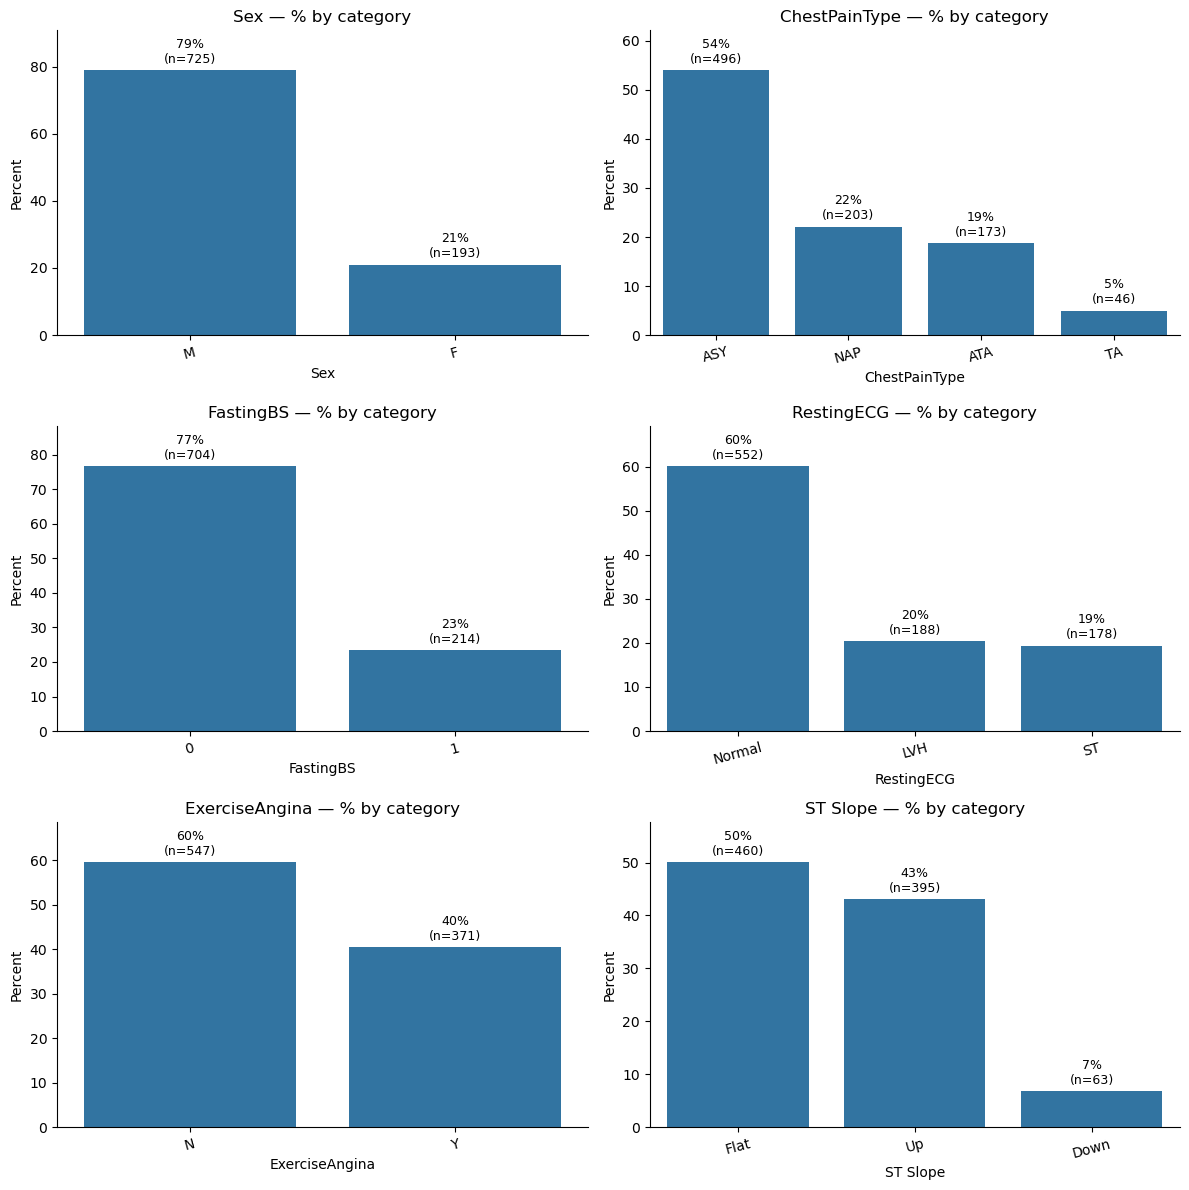

In [16]:
summary_cat = barplots_cat_univariate(
    data, cat_vars, n_cols=2, decimals=0, show_counts=True, order="desc"
)
summary_cat.head()

### Associations between Categorical variables and HeartDisease 

The plots below show, for each categorical predictor, the **proportion of HeartDisease=1 within each category**. This helps visualize how the outcome distribution varies across levels.

- **Sex.** The `Male` category shows a higher share of HeartDisease than `Female`. Note that the sample is ~80% male overall, so impressions should be confirmed with a formal test and effect size (chi-square, Cramér’s V).

- **ChestPainType.** `ASY` (asymptomatic) has a high within-category rate of HeartDisease (≈ large majority). In contrast, `ATA` (atypical angina) skews toward HeartDisease=0 (most patients in this category do **not** have HeartDisease). `NAP` shows a milder version of the `ATA` pattern.

- **FastingBS.** Patients with `FastingBS=1` (≥120 mg/dL) exhibit a higher HeartDisease rate than those with `FastingBS=0`.

- **ExerciseAngina.** `Yes` corresponds to a notably higher HeartDisease proportion (often >80% in this sample), suggesting strong predictive utility.

- **ST_Slope.** `Flat` and `Down` levels appear to have a large signal for HeartDisease=1 relative to `Up`; `Down` is rare, so its estimate is less stable.

**Takeaways.** Visual evidence points to **ChestPainType**, **ExerciseAngina**, **FastingBS**, and **ST_Slope** as the strongest categorical signals, with **Sex** also associated but potentially confounded by sampling imbalance.

> _Notes._ (i) Treat rare categories cautiously (wide sampling error); consider collapsing if appropriate.  
> (ii) We will quantify these patterns with chi-square tests and **Cramér’s V** and reflect this in encoding choices (one-hot with possible level consolidation).  
> (iii) All statements are **associations** in this dataset and not causal claims.


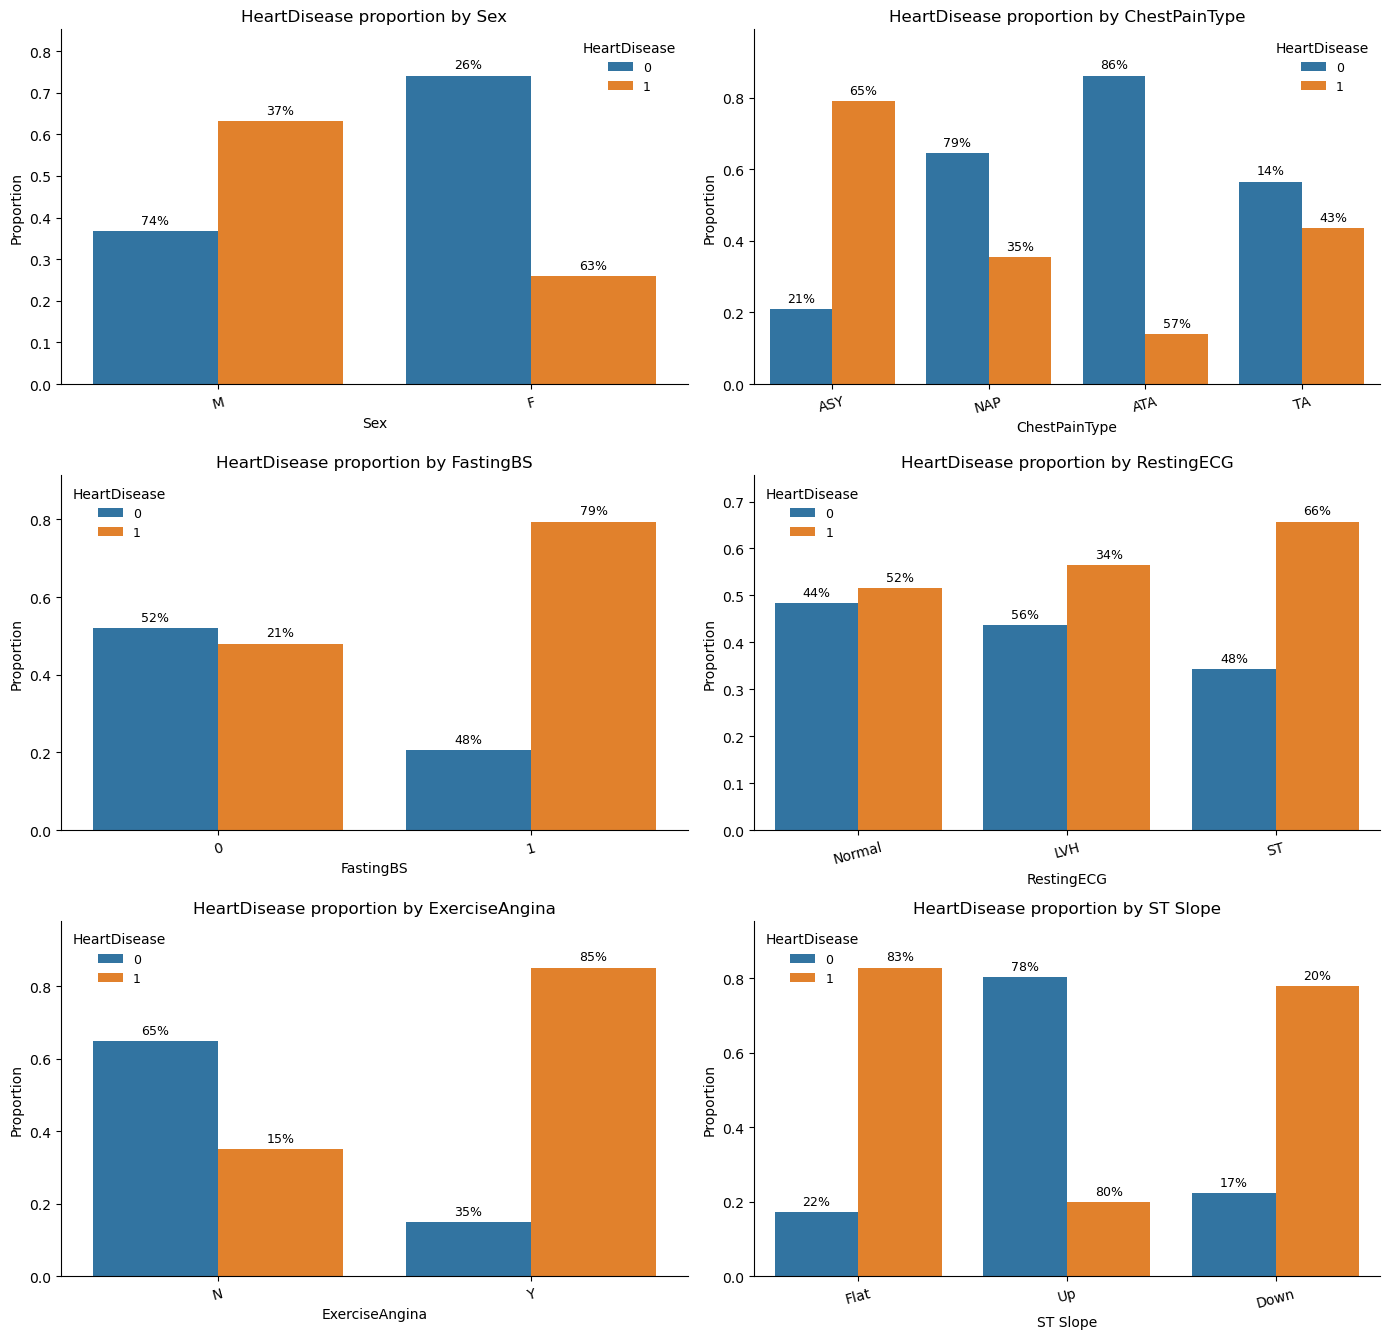

In [17]:
barplots_by_category_labeled(data, cat_vars, target="HeartDisease", n_cols=2, decimals=0)


### Cramer's V Summary

We computed Cramer's V to quantify the association between each categorical predictor and `HeartDisease`.  
Cramer's V ranges from **0 (no association)** to **1 (perfect association)**.

**Findings**
- **ST_Slope**, **ChestPainType**, and **ExerciseAngina** show the strongest associations, consistent with the bar-plot patterns.  
- **Sex** and **FastingBS** demonstrate moderate associations.  
- **RestingECG** shows only a weak/negligible association.

**Implications for modeling**
- These results suggest that the categorical predictors carry useful signal for classification.  
- For parsimonious models, we might consider **excluding RestingECG**, given its low association.  


In [19]:
cv_summary = cramers_v_table_scipy(data, cat_vars, target="HeartDisease")
cv_summary

,variable,levels,cramers_v
5,ST_Slope,3,0.623
1,ChestPainType,4,0.540
4,ExerciseAngina,2,0.492
0,Sex,2,0.303
2,FastingBS,2,0.265
3,RestingECG,3,0.109


## Summary: Categorical Variables association with HeartDisease

**Key associations (Cramér’s V):**
- **ST_Slope** ($V \approx 0.623$) — strongest signal: `Flat`/`Down` levels show higher HeartDisease rates than `Up`.
- **ChestPainType** ($V \approx 0.540$) — `ASY` enriched for HeartDisease; `ATA` skews toward no HeartDisease; `NAP` milder version of `ATA`.
- **ExerciseAngina** ($V \approx 0.492$) — `Yes` has notably higher HeartDisease proportion.
- **Sex** ($V \approx 0.303$) — males show higher HeartDisease share; interpret with care due to overall male majority (~80%).
- **FastingBS** ($V \approx 0.265$) — `1` ($\ge120 $mg/dL) associated with higher HeartDisease rate than `0`.
- **RestingECG** ($V \approx 0.109$) — weak/negligible association.

**Distribution notes (univariate context):**
- `Sex` is imbalanced (~80% male).
- `ChestPainType`: `ASY` common ($~53\%$); `TA` rare (5%).
- `ST_Slope`: mostly `Flat` (51%) / `Up` (43%); `Down` is rare (6%).
- `ExerciseAngina`: majority `No` (60%).
- `FastingBS`: mostly `0` (77%).
- `RestingECG`: `Normal` 61%; others split.

**Implications for modeling:**
- Prioritize **ST_Slope**, **ChestPainType**, **ExerciseAngina**; include **Sex** and **FastingBS** as supportive predictors.
- Consider collapsing **rare levels** (e.g., `ST_Slope=Down` if too sparse) or using regularization to stabilize estimates.
- **RestingECG** is a candidate for exclusion in parsimonious specs; we’ll confirm via model comparison.
- Use standard one-hot encoding and check contributions in cross-validation.
---
 **Overall**: Categorical predictors carry substantial signal—especially `ST_Slope`, `ChestPainType`, and `ExerciseAngina`—and align with the visual patterns observed in grouped bar plots.

**Next steps**: We begin our modeeling process in the next notebook.